In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision.datasets import MNIST
from torchvision.transforms import transforms


from custmized_layer import convLayer, poolLayer, denseLayer

from datetime import datetime

import matplotlib
#matplotlib.use('Inline')
import matplotlib.pyplot as plt
from tqdm import tqdm

import yaml

In [81]:
# some handy function 
def save_model(name, model):
    print("Saving models...")
    model.eval()

    save_model_filename = 'saved_models/' + name + '.pt'

    torch.save(model.state_dict(), save_model_filename)
    
def load_model(name, model):
    model.load_state_dict(torch.load('saved_models/' + name + '.pt'))

def load_dict(name):
    return torch.load('saved_models/' + name + '.pt')    

def test_acc(dataloader ,model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels =  data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network: %d %%' % (
        100 * correct / total))


# the learningStat class    
class learningStat():
    '''
    This class collect the learning statistics over the epoch.

    Usage:

    This class is designed to be used with learningStats instance although it can be used separately.

    >>> trainingStat = learningStat()
    '''
    def __init__(self):
        self.lossSum = 0
        self.correctSamples = 0
        self.numSamples = 0
        self.minloss = None
        self.maxAccuracy = None
        self.lossLog = []
        self.accuracyLog = []
        self.bestLoss = False
        self.bestAccuracy = False

    def reset(self):
        '''
        Reset the learning staistics. 
        This should usually be done before the start of an epoch so that new statistics counts can be accumulated.

        Usage:

        >>> trainingStat.reset()
        '''
        self.lossSum = 0
        self.correctSamples = 0
        self.numSamples = 0

    def loss(self):
        '''
        Returns the average loss calculated from the point the stats was reset.

        Usage:

        >>> loss = trainingStat.loss()
        '''
        if self.numSamples > 0: 
            return self.lossSum/self.numSamples 
        else:   
            return None

    def accuracy(self):
        '''
        Returns the average accuracy calculated from the point the stats was reset.

        Usage:

        >>> accuracy = trainingStat.accuracy()
        '''
        if self.numSamples > 0 and self.correctSamples > 0:
            return self.correctSamples/self.numSamples  
        else:   
            return None

    def update(self):
        '''
        Updates the stats of the current session and resets the measures for next session.

        Usage:

        >>> trainingStat.update()
        '''
        currentLoss = self.loss()
        self.lossLog.append(currentLoss)
        if self.minloss is None:
            self.minloss = currentLoss
        else:
            if currentLoss < self.minloss:
                self.minloss = currentLoss
                self.bestLoss = True
            else:
                self.bestLoss = False
            # self.minloss = self.minloss if self.minloss < currentLoss else currentLoss

        currentAccuracy = self.accuracy()
        self.accuracyLog.append(currentAccuracy)
        if self.maxAccuracy is None:
            self.maxAccuracy = currentAccuracy
        else:
            if currentAccuracy > self.maxAccuracy:
                self.maxAccuracy = currentAccuracy
                self.bestAccuracy = True
            else:
                self.bestAccuracy = False
            # self.maxAccuracy = self.maxAccuracy if self.maxAccuracy > currentAccuracy else currentAccuracy

    def displayString(self):
        loss = self.loss()
        accuracy = self.accuracy()
        minloss = self.minloss
        maxAccuracy = self.maxAccuracy

        if loss is None:    # no stats available
            return None
        elif accuracy is None: 
            if minloss is None: # accuracy and minloss stats is not available
                return 'loss = %-12.5g'%(loss)
            else:   # accuracy is not available but minloss is available
                return 'loss = %-12.5g (min = %-12.5g)'%(loss, minloss)
        else:
            if minloss is None and maxAccuracy is None: # minloss and maxAccuracy is available
                return 'loss = %-12.5g        %-12s   \taccuracy = %-10.5g        %-10s '%(loss, ' ', accuracy, ' ')
            else:   # all stats are available
                return 'loss = %-12.5g (min = %-12.5g)  \taccuracy = %-10.5g (max = %-10.5g)'%(loss, minloss, accuracy, maxAccuracy)

class learningStats():
    '''
    This class provides mechanism to collect learning stats for training and testing, and displaying them efficiently.

    Usage:

    .. code-block:: python
    
        stats = learningStats()

        for epoch in range(100):
            tSt = datetime.now()

            stats.training.reset()
            for i in trainingLoop:
                # other main stuffs
                stats.training.correctSamples += numberOfCorrectClassification
                stats.training.numSamples     += numberOfSamplesProcessed
                stats.training.lossSum        += currentLoss
                stats.print(epoch, i, (datetime.now() - tSt).total_seconds())
            stats.training.update()

            stats.testing.reset()
            for i in testingLoop
                # other main stuffs
                stats.testing.correctSamples += numberOfCorrectClassification
                stats.testing.numSamples     += numberOfSamplesProcessed
                stats.testing.lossSum        += currentLoss
                stats.print(epoch, i)
            stats.training.update()

    '''
    def __init__(self):
        self.linesPrinted = 0
        self.training = learningStat()
        self.testing  = learningStat()

    def update(self):
        '''
        Updates the stats for training and testing and resets the measures for next session.

        Usage:

        >>> stats.update()
        '''
        self.training.update()
        self.training.reset()
        self.testing.update()
        self.testing.reset()

    def print(self, epoch, iter=None, timeElapsed=None):
        '''
        Prints the available learning statistics from the current session on the console.
        For Linux systems, prints the data on same terminal space (might not work properly on other systems).

        Arguments:
            * ``epoch``: epoch counter to display (required).
            * ``iter``: iteration counter to display (not required).
            * ``timeElapsed``: runtime information (not required).

        Usage:

        .. code-block:: python

            # prints stats with epoch index provided
            stats.print(epoch) 

            # prints stats with epoch index and iteration index provided
            stats.print(epoch, iter=i) 
            
            # prints stats with epoch index, iteration index and time elapsed information provided
            stats.print(epoch, iter=i, timeElapsed=time) 
        '''
        print('\033[%dA'%(self.linesPrinted))
        
        self.linesPrinted = 1

        epochStr   = 'Epoch : %10d'%(epoch)
        iterStr    = '' if iter is None else '(i = %7d)'%(iter)
        profileStr = '' if timeElapsed is None else ', %12.4f ms elapsed'%(timeElapsed * 1000)

        print(epochStr + iterStr + profileStr)
        print(self.training.displayString())
        self.linesPrinted += 2
        if self.testing.displayString() is not None:
            print(self.testing.displayString())
            self.linesPrinted += 1

    def plot(self, figures=(1, 2), saveFig=False, path=''):
        '''
        Plots the available learning statistics.

        Arguments:
            * ``figures``: Index of figure ID to plot on. Default is figure(1) for loss plot and figure(2) for accuracy plot.
            * ``saveFig``(``bool``): flag to save figure into a file.
            * ``path``: path to save the file. Defaule is ``''``.

        Usage:

        .. code-block:: python

            # plot stats
            stats.plot() 

            # plot stats figures specified
            stats.print(figures=(10, 11)) 
        '''
        plt.figure(figures[0])
        plt.cla()
        if len(self.training.lossLog) > 0:
            plt.semilogy(self.training.lossLog, label='Training')
        if len(self.testing.lossLog) > 0:
            plt.semilogy(self.testing .lossLog, label='Testing')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        if saveFig is True: 
            plt.savefig(path + 'loss.png')
            # plt.close()

        plt.figure(figures[1])
        plt.cla()
        if len(self.training.accuracyLog) > 0:
            plt.plot(self.training.accuracyLog, label='Training')
        if len(self.testing.accuracyLog) > 0:
            plt.plot(self.testing .accuracyLog, label='Testing')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend() 
        if saveFig is True: 
            plt.savefig(path + 'accuracy.png')
            # plt.close()

    def save(self, filename=''):
        '''
        Saves the learning satatistics logs.

        Arguments:
            * ``filename``: filename to save the logs. ``accuracy.txt`` and ``loss.txt`` will be appended

        Usage:

        .. code-block:: python

            # save stats
            stats.save() 

            # save stats filename specified
            stats.save(filename='Run101-0.001-') # Run101-0.001-accuracy.txt and Run101-0.001-loss.txt
        '''

        with open(filename + 'loss.txt', 'wt') as loss:
            loss.write('#%11s %11s\r\n'%('Train', 'Test'))
            for i in range(len(self.training.lossLog)): 
                loss.write('%12.6g %12.6g \r\n'%(self.training.lossLog[i], self.testing.lossLog[i]))

        with open(filename + 'accuracy.txt', 'wt') as accuracy:
            accuracy.write('#%11s %11s\r\n'%('Train', 'Test'))
            if self.training.accuracyLog != [None]*len(self.training.accuracyLog):
                for i in range(len(self.training.accuracyLog)): 
                    accuracy.write('%12.6g %12.6g \r\n'%(self.training.accuracyLog[i], self.testing.accuracyLog[i]))

# Test for raw and tailored CNN with MNIST

In [152]:
# set up hyper params
BATCH_SIZE  = 128

EPOCH = 5

use_cuda = torch.cuda.is_available()

torch.manual_seed(1024)

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

## Dataset preparation for CNNs

In [144]:
# # small version of MNIST for experiment

# class MNIST500(Dataset):
#     def __init__(self, datasetPath, train=False):
#         self.path = datasetPath
#         ds = MNIST(datasetPath, train=train, download=True, transform=transforms.Compose([
#             transforms.ToTensor()]))
#         self.samples = [ds[i] for i in range(0, 500)]

#     def __getitem__(self, index):
#         x, y = self.samples[index]
#         return x, y

#     def __len__(self):
#         return len(self.samples)
    
# trainset_cnn = MNIST500(datasetPath='./data', train=True)

# trainloader_cnn = torch.utils.data.DataLoader(trainset_cnn, batch_size=BATCH_SIZE,
#                                           shuffle=True, num_workers=2)

# testset_cnn = MNIST500(datasetPath='./data', train=False)

# testloader_cnn = torch.utils.data.DataLoader(testset_cnn, batch_size=BATCH_SIZE,
#                                          shuffle=False, num_workers=2)

# classes = ('zero', 'one', 'two', 'three',
#            'four', 'five', 'six', 'seven', 'eight', 'nine')

In [153]:
trainset_cnn = MNIST(root='./data', train=True, transform=transforms.Compose([
            transforms.ToTensor()]))

trainloader_cnn = torch.utils.data.DataLoader(trainset_cnn, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testset_cnn = MNIST(root='./data', train=False, transform=transforms.Compose([
            transforms.ToTensor()]))

testloader_cnn = torch.utils.data.DataLoader(testset_cnn, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

classes = ('zero', 'one', 'two', 'three',
           'four', 'five', 'six', 'seven', 'eight', 'nine')

## Training for CNNs
* define the two CNNs
* define the train function
* train them and check the results

In [175]:
class Raw_CNN(nn.Module):
    def __init__(self):
        super(Raw_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, 5, padding=1, bias=True)
        self.conv2 = nn.Conv2d(3, 12, 5, padding=1, bias=True)
        self.m1 = nn.MaxPool2d(2)
        self.m2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(12 * 5 * 5, 10, bias=True)

    def forward(self, x):
        x = F.relu(self.conv1(x)) 
        x = self.m1(x) 
        x = F.relu(self.conv2(x)) 
        x = self.m2(x) 
        x = x.view(-1, 12 * 5 * 5)    
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

class Tailored_CNN(nn.Module):
    def __init__(self):
        super(Tailored_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, 5, padding=1, bias=False)
        self.conv2 = nn.Conv2d(3, 12, 5, padding=1, bias=False)
        self.a1 = nn.AvgPool2d(2)
        self.a2 = nn.AvgPool2d(2)
        self.fc1 = nn.Linear(12 * 5 * 5, 10, bias=False)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.a1(x)
        x = F.relu(self.conv2(x))
        x = self.a2(x)
        x = x.view(-1, 12 * 5 * 5)   
        x = self.fc1(x) 
        return F.log_softmax(x, dim=1)

In [155]:
def plot_stats(stats):
    plt.figure(1)
    plt.semilogy(stats.training.lossLog, label='Training')
    plt.semilogy(stats.testing.lossLog, label='Testing')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.figure(2)
    plt.plot(stats.training.accuracyLog, label='Training')
    plt.plot(stats.testing.accuracyLog, label='Testing')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

## Training
def train(model, model_name, trainloader, testloader, criterion, optimizer, stats, epoch):
    
    for epoch in tqdm(range(epoch)):
        # Reset training stats.
        stats.training.reset()
        tSt = datetime.now()
        model.train()    
        # Training loop.
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)

            loss = criterion(outputs, labels)

            loss.backward()

            optimizer.step()

            # Gather training loss stats.
            stats.training.lossSum += loss.cpu().data.item()

            # Gather the training stats.
            _, predicted = torch.max(outputs.data, 1)

            stats.training.correctSamples += torch.sum(predicted == labels).data.item()
            stats.training.numSamples += len(labels)

            # Display training stats.
            # if i%10 == 0: stats.print(epoch, i, (datetime.now() - tSt).total_seconds())
        # Update training stats.
        stats.training.update()
        # Reset testing stats.
        stats.testing.reset()
        model.eval()    
        # Testing loop.
        # Same steps as Training loops except loss backpropagation and weight update.
        for i, data in enumerate(testloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            outputs = model.forward(inputs)
            _, predicted = torch.max(outputs.data, 1)

            stats.testing.correctSamples += torch.sum(predicted == labels).data.item()
            stats.testing.numSamples += len(labels)

            loss = criterion(outputs, labels)
            stats.testing.lossSum += loss.cpu().data.item()


        # Update stats.
        stats.testing.update()
        if epoch%2==0:  stats.print(epoch, timeElapsed=(datetime.now() - tSt).total_seconds())
    print('Finished Training')
    
    test_acc(testloader, model)
    plot_stats(stats)
    save_model(model_name, model)

def test(model, model_name, testloader):
    load_model(model_name, model)
    test_acc(testloader, model)



  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:05<00:21,  5.49s/it]


Epoch :          0,    5493.8340 ms elapsed
loss = 0.0039348    (min = 0.0039348   )  	accuracy = 0.86032    (max = 0.86032   )
loss = 0.0012798    (min = 0.0012798   )  	accuracy = 0.9508     (max = 0.9508    )




 40%|████      | 2/5 [00:11<00:16,  5.56s/it]

 60%|██████    | 3/5 [00:16<00:11,  5.61s/it]


Epoch :          2,    5746.9520 ms elapsed
loss = 0.00087041   (min = 0.00087041  )  	accuracy = 0.96628    (max = 0.96628   )
loss = 0.00075854   (min = 0.00075854  )  	accuracy = 0.9698     (max = 0.9698    )




 80%|████████  | 4/5 [00:22<00:05,  5.60s/it]

100%|██████████| 5/5 [00:27<00:00,  5.50s/it]


Epoch :          4,    5262.6160 ms elapsed
loss = 0.00061417   (min = 0.00061417  )  	accuracy = 0.97587    (max = 0.97587   )
loss = 0.00049813   (min = 0.00049813  )  	accuracy = 0.9792     (max = 0.9792    )
Finished Training
Accuracy of the network: 97 %


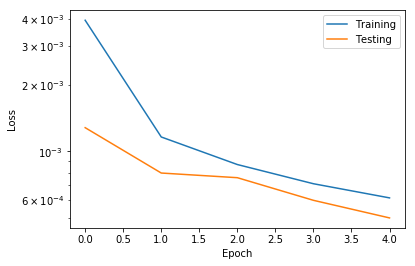

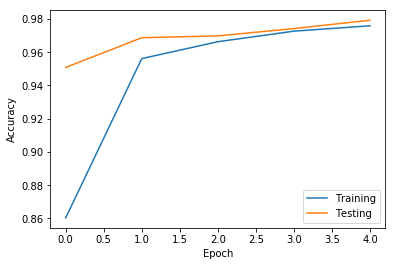

Saving models...


In [176]:
raw_cnn = Raw_CNN().to(device)

raw_criterion = nn.CrossEntropyLoss()
raw_optimizer = optim.Adam(raw_cnn.parameters(), lr=0.001)
raw_stats = learningStats()

train(raw_cnn,'raw_cnn_500',
      trainloader_cnn,testloader_cnn,
      raw_criterion, 
      raw_optimizer,
      raw_stats,
      epoch=EPOCH)

In [10]:
# raw_cnn = Raw_CNN().to(device)
# test(raw_cnn, 'raw_cnn_500', testloader_cnn)

Accuracy of the network on the 10000 test images: 91 %




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:05<00:21,  5.44s/it]


Epoch :          0,    5440.8710 ms elapsed
loss = 0.004539     (min = 0.004539    )  	accuracy = 0.84322    (max = 0.84322   )
loss = 0.0019938    (min = 0.0019938   )  	accuracy = 0.9273     (max = 0.9273    )




 40%|████      | 2/5 [00:10<00:16,  5.45s/it]

 60%|██████    | 3/5 [00:16<00:10,  5.48s/it]


Epoch :          2,    5546.4030 ms elapsed
loss = 0.0011361    (min = 0.0011361   )  	accuracy = 0.95803    (max = 0.95803   )
loss = 0.00088877   (min = 0.00088877  )  	accuracy = 0.9664     (max = 0.9664    )




 80%|████████  | 4/5 [00:22<00:05,  5.50s/it]

100%|██████████| 5/5 [00:27<00:00,  5.50s/it]


Epoch :          4,    5492.0640 ms elapsed
loss = 0.00077153   (min = 0.00077153  )  	accuracy = 0.9712     (max = 0.9712    )
loss = 0.00064431   (min = 0.00064431  )  	accuracy = 0.9754     (max = 0.9754    )
Finished Training
Accuracy of the network: 97 %


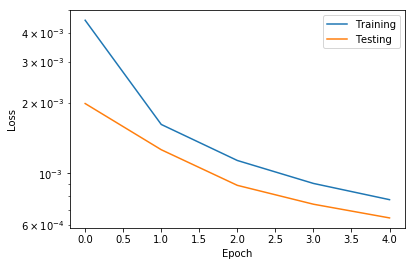

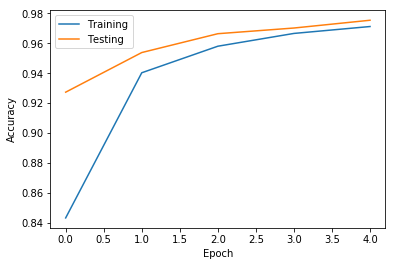

Saving models...


In [177]:
tailored_cnn = Tailored_CNN().to(device)

t_criterion = nn.CrossEntropyLoss()
t_optimizer = optim.Adam(tailored_cnn.parameters(), lr=0.001)
t_stats = learningStats()

train(tailored_cnn,'tailor_cnn_500', 
      trainloader_cnn,testloader_cnn, 
      t_criterion, 
      t_optimizer,
      t_stats,
      epoch=EPOCH)

In [12]:
# tailored_cnn = Tailored_CNN().to(device)
# test(tailored_cnn, 'tailor_cnn_500', testloader_cnn)

Accuracy of the network on the 10000 test images: 89 %


# Test for SNN with weights from tailored CNN

In [167]:
# set up hyper params
time_bins = 100

In [160]:
class yamlParams(object):
    '''
    This class reads yaml parameter file and allows dictionary like access to the members.

    Usage:

    .. code-block:: python

        import slayerSNN as snn
        netParams = snn.params('path_to_yaml_file')	# OR
        netParams = yamlParams('path_to_yaml_file')

        netParams['training']['learning']['etaW'] = 0.01
        print('Simulation step size        ', netParams['simulation']['Ts'])
        print('Spiking neuron time constant', netParams['neuron']['tauSr'])
        print('Spiking neuron threshold    ', netParams['neuron']['theta'])

        netParams.save('filename.yaml')
    '''
    def __init__(self, parameter_file_path):
        with open(parameter_file_path, 'r') as param_file:
            self.parameters = yaml.safe_load(param_file)

    # Allow dictionary like access
    def __getitem__(self, key):
        return self.parameters[key]

    def __setitem__(self, key, value):
        self.parameters[key] = value

    def save(self, filename):
        with open(filename, 'w') as f:
            yaml.dump(self.parameters, f)

class spikeClassifier:
    '''
    It provides classification modules for SNNs.
    All the functions it supplies are static and can be called without making an instance of the class.
    '''
    @staticmethod
    def getClass(spike):
        '''
        Returns the predicted class label.
        It assignes single class for the SNN output for the whole simulation runtime.

        Usage:

        >>> predictedClass = spikeClassifier.getClass(spikeOut)
        '''
        numSpikes = torch.sum(spike, 4, keepdim=True).cpu()
        return torch.max(numSpikes.reshape((numSpikes.shape[0], -1)), 1)[1]

In [194]:
# func to generate spikes
def poisson_spike(x, time_bins):
    shape_org = list(x.shape)
    y = x.reshape(-1)
    samples = []
    for yy in y:
        m1 = Poisson(yy)
        samples.append(m1.sample(sample_shape=(time_bins,)) > 0)
    output = torch.stack(samples, dim=0).float()
    return output.reshape(shape_org + [time_bins])


def uniform_spike(x, time_bins):
    shape_org = list(x.shape)
    shape_target = shape_org + [time_bins]
    output = torch.rand(shape_target)
    a = x.unsqueeze(-1)
    b = torch.cat(time_bins * [a], dim=-1)
    C = 0.33
    output = (C * b > output)
    return output.float()

class SMNIST(Dataset):
    def __init__(self, datasetPath, TimeBins=25, small=True, train=True, encoding='uniform',
                 mode='classification'):
        self.mode = mode
        self.path = datasetPath
        if small:
            ds = MNIST(datasetPath, train=train, download=True, transform=transforms.Compose([
                transforms.ToTensor()]))
            self.samples = [ds[i] for i in range(0, 500)]
        else:
            self.samples = MNIST(datasetPath, train=train, download=True, transform=transforms.Compose([
                transforms.ToTensor()]))
        
        self.nTimeBins = TimeBins
        self.encoding = encoding

    def __getitem__(self, index):
        x, classLabel = self.samples[index]
        if self.encoding == 'uniform':
            x_spikes = uniform_spike(x, self.nTimeBins)
        else:
            x_spikes = poisson_spike(x, self.nTimeBins)
        if self.mode == 'classification':
            desiredClass = torch.zeros((10, 1, 1, 1))
            desiredClass[classLabel, ...] = 1
            return x_spikes, desiredClass, classLabel
        elif self.mode == 'autoencoder':
            return x_spikes, x, classLabel
        elif self.mode == 'autoencoderSpike':
            return x_spikes, x_spikes, classLabel
        else:
            raise Exception(
                'mode is not valid {}. Valid are classification, autoencoder, autoencoderSpike'.format(self.mode))

    def __len__(self):
        return len(self.samples)

In [195]:
class custmized_SNN(nn.Module):
    
    def __init__(self, thetas, leaks=[0,0,0,0,0], V_min=[0,0,0,0,0]):
        super(custmized_SNN, self).__init__()
        self.conv1 = convLayer(1, 3, 5, theta=thetas[0], padding=1)
        self.pool1 = poolLayer(2, theta=thetas[1])
        self.conv2 = convLayer(3, 12, 5, theta=thetas[2],padding=1)        
        self.pool2 = poolLayer(2, theta=thetas[3])
        self.fc1   = denseLayer((5 * 5 * 12), 10, theta=thetas[4])
        
    def forward(self, spikeInput):
        spike_conv1 = self.conv1(spikeInput)
        #print(spike_conv1)
        spike_pool1 = self.pool1(spike_conv1)
        #print(spike_pool1)
        spike_conv2 = self.conv2(spike_pool1)
        #print(spike_conv2.shape)
        spike_pool2 = self.pool2(spike_conv2)
        spike_for_fc1 = spike_pool2.reshape(-1, 5 * 5 * 12, 1, 1, spike_pool2.shape[-1])
        spikeOut = self.fc1(spike_for_fc1)
        
        return spikeOut        

## define the custmized SNN and the transformed MNIST dataset

In [198]:
thetas = [1, 0.99, 1, 0.99, 1]

custmized_snn = custmized_SNN(thetas=thetas).to(device)

In [180]:
netParams = yamlParams('network_specs/slayer_snn.yaml')

In [197]:
# Dataset and dataLoader instances.

testingSet = SMNIST(datasetPath  =netParams['training']['path']['in'], TimeBins=30,
                    small=False, train=False)

testLoader = DataLoader(dataset=testingSet, batch_size=64, shuffle=False, num_workers=4)

### check the performance of a randomly initialized SNN

In [199]:
correct = 0

for i, (input, target, label) in enumerate(testLoader, 0):
    input = input.to(device)
    target = target.to(device)

    output = custmized_snn(input)

    correct += torch.sum(spikeClassifier.getClass(output) == label).data.item()

In [200]:
correct/len(testingSet)

0.1009

### now try with the weights learned from tailor_cnn

In [201]:
# script to transport the weights
tailor_cnn_weights = load_dict("tailor_cnn_500")
snn_weights = custmized_snn.state_dict()

for k in iter(tailor_cnn_weights):
    print("Layer {}".format(k))
    print(tailor_cnn_weights[k].shape)
    if k.startswith('conv') or k.startswith('fc'):
        snn_weights[k] = tailor_cnn_weights[k].reshape(snn_weights[k].shape)

Layer conv1.weight
torch.Size([3, 1, 5, 5])
Layer conv2.weight
torch.Size([12, 3, 5, 5])
Layer fc1.weight
torch.Size([10, 300])


In [202]:
custmized_snn_cnn = custmized_SNN(thetas=thetas).to(device)
custmized_snn_cnn.load_state_dict(snn_weights)

# this warning can be ignored, it happens when using jupyter 
# even the weights are passed without problem

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [203]:
correct = 0

for i, (input, target, label) in enumerate(testLoader, 0):
    input = input.to(device)
    target = target.to(device)

    output = custmized_snn_cnn(input)

    correct += torch.sum(spikeClassifier.getClass(output) == label).data.item()

In [204]:
correct/len(testingSet)

0.8695